## Information about this notebook

This example script was provided as part of the Data Management Project (INF) within the TR-172 ["ArctiC Amplification: Climate Relevant Atmospheric and SurfaCe Processes, and Feedback Mechanisms" (AC)³](http://www.ac3-tr.de/) funded by the German Research Foundation (Deutsche Forschungsgemeinschaft, DFG)

Author: Matthias Buschmann, [Institute of Environmental Physics](http://www.iup.uni-bremen.de), University of Bremen, Germany, m_buschmann@iup.physik.uni-bremen.de

Github repository: https://github.com/ac3-tr/ac3-notebooks

**Setup instructions for a reference Python Environment can be found on the [Github page](https://github.com/ac3-tr/ac3-notebooks)**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import cartopy.crs as ccrs
from copy import copy

%matplotlib inline

# In-situ Chlorophyll a concentrations

## Dataset resources

**Title:** Global data sets of Chlorophyll "a" concentration for diatoms, coccolithophores (haptophytes) and cyanobacteria obtained from in situ observations and satellite retrievals    

**Authors** Losa, Svetlana; Soppa, Mariana A; Dinter, Tilman; Wolanin, Aleksandra; Brewin, Robert J W; Bricaud, Annick; Oelker, Julia; Peeken, Ilka; Gentili, Bernard; Rozanov, Vladimir V; Bracher, Astrid    

**Year** 2017      

**DOI** https://doi.org/10.1594/PANGAEA.873210       

**License**    [Creative Commons Attribution 3.0 Unported](http://creativecommons.org/licenses/by/3.0/ "CC-BY-3.0")

**Linked Publication** Losa, S et al. (2017): Synergistic Exploitation of Hyper- and Multi-Spectral Precursor Sentinel Measurements to Determine
Phytoplankton Functional Types (SynSenPFT). Frontiers in Marine Science, 4(203), 22 pp, https://doi.org/10.3389/fmars.2017.00203

## Abstract
We derive the chlorophyll a concentration (Chla) for three main phytoplankton functional types (PFTs)-- diatoms, coccolithophores and cyanobacteria- by combining satellite multispectral-based information, being of a high spatial and temporal resolution, with retrievals based on high resolution of PFT absorption properties derived from hyperspectral measurements. The multispectral-based PFT Chla retrievals are based on a revised version of the empirical OC-PFT algorithm (Hirata et al. 2011) applied to the Ocean Colour Climate Change Initiative (OC-CCI) total Chla product. The PhytoDOAS analytical algorithm (Bracher et al. 2009, Sadeghi et al. 2012) is used with some modifications to derive PFT Chla from SCIAMACHY hyperspectral measurements. To combine synergistically these two PFT products (OC-PFT and PhytoDOAS), an optimal interpolation is performed for each PFT in every OC-PFT sub-pixel within a PhytoDOAS pixel, given its Chla and its a priori error statistics. The synergistic product (SynSenPFT) is presented for the period of August 2002 ? March 2012 and evaluated against in situ HPLC pigment data and satellite information on phytoplankton size classes (PSC) (Brewin et al. 2010, Brewin et al. 2015) and the size fraction (Sf) by Ciotti and Bricaud (2006. The most challenging aspects of the SynSenPFT algorithm implementation are discussed. Perspectives on SynSenPFT product improvements and prolongation of the time series over the next decades by adaptation to Sentinel multi- and hyperspectral instruments are highlighted.


## Reading example dataset

The example file containing in-situ datasets of Chlorophyll a can be downloaded via the link above and saved in the current working directory of the notebook. The appropriate header size can be checked in the ASCII file, as well as the contained names of the columns. NumPy's *recfromtxt* function is used to create a record array with the column labels given in the list *names*. The import is limited to 8 columns.

In [2]:
names = ['DateTime', 'Latitude', 'Longitude', 'Depthwater', 'TChla', 'Chladiatoms', 'ChlaHaptophyta', 'ChlaProk']
data = np.recfromtxt('./Global_Chl_a.tab', skip_header=62, names=names, usecols=[1,2,3,4,5,6,7,8], encoding='utf8')

print ('Number of datapoints in data:', data.shape)

Number of datapoints in data: (15215,)


Although the data is already read in and can be worked with, for convinience, we continue processing and applying a simple algorithm to re-grid to an arithmetic mean for a chosen resolution...

## Additional processing

In order to display the data easily, the *'TChla', 'Chladiatoms', 'ChlaHaptophyta', 'ChlaProk'* are gridded on a rectangular grid from -90° to 90° latitude and -180° to 180° longitude.

For each of the variable keys, a new 2-dimensional grid is created and stored in the dictionary *ngrid*. As this re-gridding might take a while (depending on the chosen resolutions in *dlat* and 'dlon'), an update is printed after every 10000 steps.

For each coordinate in the grid, a latitude and longitude condition is created, then combined and applied to the data field. To keep it simple, the arithmetic mean is calculated for all values that pass the condition.

In [3]:
minlat, maxlat = -90,90
minlon, maxlon = -180,180
dlat, dlon = 180, 360
deltalat, deltalon = (maxlat-minlat)/dlat, (maxlon-minlon)/dlon

sgridx, sgridy = np.meshgrid(np.linspace(minlon, maxlon, dlon), np.linspace(minlat, maxlat, dlat))
           
ngrid = {}
keys = names[4:]
for key in keys:
    ngrid[key] = np.ones((dlat,dlon))*-999

i=0
for lo in range(dlon):
    for la in range(dlat):
        if i%10000==0:
            print (i)
        i+=1
        loncond = (data['Longitude']>sgridx[la, lo]-deltalon/2) & (data['Longitude']<sgridx[la, lo]+deltalon/2)
        latcond = (data['Latitude']>sgridy[la, lo]-deltalat/2) & (data['Latitude']<sgridy[la, lo]+deltalat/2)
        cond = loncond & latcond
        if np.any(cond):
            for key in keys:
                ngrid[key][la, lo] = np.mean(data[key][cond])
        else: pass


0
10000
20000
30000
40000
50000
60000


There are still some *NaN* values in the dataset, that should be masked before plotting. The NAN-value of *-999* is masked using NumPy's masking module (*np.ma*).

Then a world map can be created using, e.g. the Cartopy module and the newly gridded data added. A standard colormap was changed to set its *NaN*-value to be transparent, i.e. the alpha value was set to 0 using the *set_bad* function.

In [4]:
tchla_m = np.ma.masked_values(ngrid['TChla'], -999)


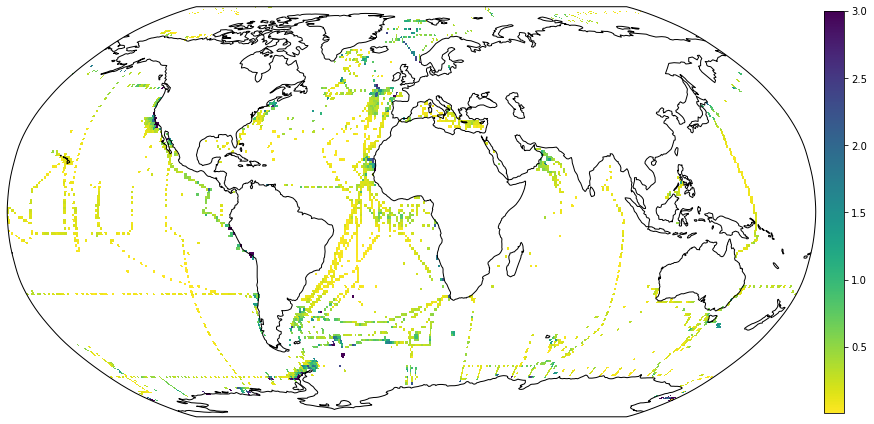

In [5]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(111, projection=ccrs.Robinson())
ax1.coastlines('110m')
palette = copy(plt.get_cmap('viridis_r'))
palette.set_bad('k', 0.0)
im = ax1.imshow(tchla_m, extent=(minlon,maxlon,minlat,maxlat), transform=ccrs.PlateCarree(), cmap=palette, 
                vmax=3, label='')
cb = fig.colorbar(im, ax=ax1, fraction=0.024, pad=0.01)